# arithmetic mean

P=1:
  RF - DR=73.23%, FPR=0.24%, ACC=98.23%
  MRMR+MI+RF - DR=74.64%, FPR=0.22%, ACC=98.37%
P=2:
  RF - DR=75.75%, FPR=0.21%, ACC=98.39%
  MRMR+MI+RF - DR=81.21%, FPR=0.19%, ACC=98.56%
P=3:
  RF - DR=77.90%, FPR=0.19%, ACC=98.55%
  MRMR+MI+RF - DR=83.73%, FPR=0.17%, ACC=98.69%
P=4:
  RF - DR=79.52%, FPR=0.19%, ACC=98.61%
  MRMR+MI+RF - DR=84.20%, FPR=0.17%, ACC=98.75%
P=5:
  RF - DR=80.99%, FPR=0.18%, ACC=98.68%
  MRMR+MI+RF - DR=85.27%, FPR=0.16%, ACC=98.84%
P=6:
  RF - DR=83.38%, FPR=0.17%, ACC=98.77%
  MRMR+MI+RF - DR=87.13%, FPR=0.15%, ACC=98.90%


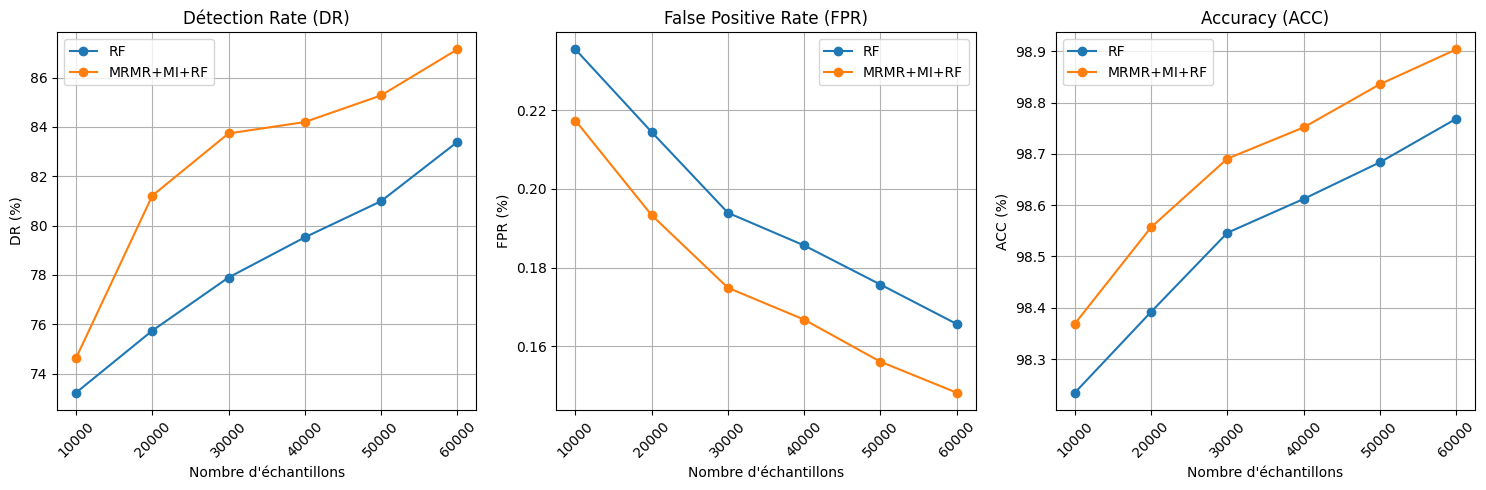

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_random_samples(filename, n_samples):
    df = pd.read_csv(filename)
    if len(df) < n_samples:
        raise ValueError(f"Not enough data in '{filename}': {len(df)} rows available, but {n_samples} required.")
    if len(df) > n_samples:
        return df.sample(n=n_samples, random_state=42)
    else:
        return df

# Chemins des dossiers
train_path = '/kaggle/input/ciciot2023/data/train'
test_path = '/kaggle/input/ciciot2023/data/test'

def mrmr_feature_selection(X, y, k=20):
   
    n_features = X.shape[1]
    
    # Normaliser les données pour de meilleures estimations d'information mutuelle
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Précalculer la matrice de redondance (MI entre toutes les paires de features)
    redundancy_matrix = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(i+1, n_features):
            mi_red = mutual_info_regression(X_normalized[:, i].reshape(-1, 1), 
                                           X_normalized[:, j])[0]
            redundancy_matrix[i, j] = mi_red
            redundancy_matrix[j, i] = mi_red
    
    # Relevance: MI entre chaque feature et la cible
    relevance = mutual_info_classif(X_normalized, y, random_state=42)
    
    selected_features = []
    remaining_features = list(range(n_features))
    
    for _ in range(k):
        candidate_scores = np.zeros(len(remaining_features))
        for idx, feat in enumerate(remaining_features):
            rel = relevance[feat]
            if selected_features:
                # Calculer la redondance moyenne avec les features déjà sélectionnées
                redundancy = np.mean([redundancy_matrix[feat, sel_feat] 
                                     for sel_feat in selected_features])
            else:
                redundancy = 0
            candidate_scores[idx] = rel - redundancy
        
        best_idx = np.argmax(candidate_scores)
        best_feat = remaining_features[best_idx]
        selected_features.append(best_feat)
        remaining_features.pop(best_idx)
    
    return selected_features

# Initialisation des listes pour stocker les métriques
DR_list_RF = []
FPR_list_RF = []
ACC_list_RF = []
DR_list_MRMR_MI_RF = []
FPR_list_MRMR_MI_RF = []
ACC_list_MRMR_MI_RF = []
sample_count_list = []

# Chargement des données de test 
benign_test = pd.read_csv(os.path.join(test_path, 'Benign_test.csv')).drop(columns=['Label'], errors='ignore')
ddos_test = pd.read_csv(os.path.join(test_path, 'DDoS_test.csv')).drop(columns=['Label'], errors='ignore')
dos_test = pd.read_csv(os.path.join(test_path, 'DoS_test.csv')).drop(columns=['Label'], errors='ignore')
mirai_test = pd.read_csv(os.path.join(test_path, 'Mirai_test.csv')).drop(columns=['Label'], errors='ignore')
recon_test = pd.read_csv(os.path.join(test_path, 'Recon_test.csv')).drop(columns=['Label'], errors='ignore')
spoofing_test = pd.read_csv(os.path.join(test_path, 'Spoofing_test.csv')).drop(columns=['Label'], errors='ignore')
webbased_test = pd.read_csv(os.path.join(test_path, 'Web-based_test.csv')).drop(columns=['Label'], errors='ignore')
bruteforce_test = pd.read_csv(os.path.join(test_path, 'Brute_Force_test.csv')).drop(columns=['Label'], errors='ignore')

# Création des labels de test
benign_test_labels = np.zeros(len(benign_test), dtype=int)
ddos_test_labels = np.ones(len(ddos_test), dtype=int)
dos_test_labels = np.full(len(dos_test), 2, dtype=int)
mirai_test_labels = np.full(len(mirai_test), 3, dtype=int)
recon_test_labels = np.full(len(recon_test), 4, dtype=int)
spoofing_test_labels = np.full(len(spoofing_test), 5, dtype=int)
webbased_test_labels = np.full(len(webbased_test), 6, dtype=int)
bruteforce_test_labels = np.full(len(bruteforce_test), 7, dtype=int)

# Fusion des données de test
TestMatrix = pd.concat([
    benign_test, ddos_test, dos_test, mirai_test,
    recon_test, spoofing_test, webbased_test, bruteforce_test
], ignore_index=True)
TestLabels = np.concatenate([
    benign_test_labels, ddos_test_labels, dos_test_labels, mirai_test_labels,
    recon_test_labels, spoofing_test_labels, webbased_test_labels, bruteforce_test_labels
])

# Gestion des valeurs infinies et manquantes pour le test
TestMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
TestMatrix.fillna(TestMatrix.mean(), inplace=True)

# Boucle sur P de 1 à 6
for P in range(1, 7):
    benign_train    = load_random_samples(os.path.join(train_path, 'Benign_train.csv'), 2229 * P).drop(columns=['Label'], errors='ignore')
    ddos_train      = load_random_samples(os.path.join(train_path, 'DDoS_train.csv'), 2704 * P).drop(columns=['Label'], errors='ignore')
    dos_train       = load_random_samples(os.path.join(train_path, 'DoS_train.csv'), 1307 * P).drop(columns=['Label'], errors='ignore')
    mirai_train     = load_random_samples(os.path.join(train_path, 'Mirai_train.csv'), 627 * P).drop(columns=['Label'], errors='ignore')
    recon_train     = load_random_samples(os.path.join(train_path, 'Recon_train.csv'), 940 * P).drop(columns=['Label'], errors='ignore')
    spoofing_train  = load_random_samples(os.path.join(train_path, 'Spoofing_train.csv'), 2066 * P).drop(columns=['Label'], errors='ignore')
    webbased_train  = load_random_samples(os.path.join(train_path, 'Web-based_train.csv'), 59 * P).drop(columns=['Label'], errors='ignore')
    bruteforce_train= load_random_samples(os.path.join(train_path, 'Brute_Force_train.csv'), 68 * P).drop(columns=['Label'], errors='ignore')
    # Création des labels d'entraînement
    benign_labels = np.zeros(len(benign_train), dtype=int)
    ddos_labels = np.ones(len(ddos_train), dtype=int)
    dos_labels = np.full(len(dos_train), 2, dtype=int)
    mirai_labels = np.full(len(mirai_train), 3, dtype=int)
    recon_labels = np.full(len(recon_train), 4, dtype=int)
    spoofing_labels = np.full(len(spoofing_train), 5, dtype=int)
    webbased_labels = np.full(len(webbased_train), 6, dtype=int)
    bruteforce_labels = np.full(len(bruteforce_train), 7, dtype=int)

    # Fusion des données d'entraînement
    TrainMatrix = pd.concat([
        benign_train, ddos_train, dos_train, mirai_train,
        recon_train, spoofing_train, webbased_train, bruteforce_train
    ], ignore_index=True)
    TrainLabels = np.concatenate([
        benign_labels, ddos_labels, dos_labels, mirai_labels,
        recon_labels, spoofing_labels, webbased_labels, bruteforce_labels
    ])

    # Gestion des valeurs infinies et manquantes pour l'entraînement
    TrainMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
    TrainMatrix.fillna(TrainMatrix.mean(), inplace=True)

    # --- Méthode Random Forest standard ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(TrainMatrix, TrainLabels)
    pred_labels = rf.predict(TestMatrix)

    # Calcul métriques pour RF standard
    conf_mat = confusion_matrix(TestLabels, pred_labels, labels=np.unique(TestLabels))
    TP = np.diag(conf_mat)
    FN = np.sum(conf_mat, axis=1) - TP
    FP = np.sum(conf_mat, axis=0) - TP
    TN = np.sum(conf_mat) - (TP + FP + FN)

    DR_RF = np.mean(TP / (TP + FN)) * 100
    FPR_RF = np.mean(FP / (FP + TN)) * 100
    ACC_RF = np.sum(TP) / np.sum(conf_mat) * 100

    # --- Méthode MRMR + MI + RF ---
    k = 20  # Nombre de caractéristiques à sélectionner
    # Use MRMR to select k=20 features (MRMR uses MI internally)
    selected_mrmr = mrmr_feature_selection(TrainMatrix.values, TrainLabels, k=k)
    TrainMatrix_mrmr = TrainMatrix.iloc[:, selected_mrmr].values
    TestMatrix_mrmr = TestMatrix.iloc[:, selected_mrmr].values

    # Entraînement RF sur caractéristiques sélectionnées par MRMR
    rf_mrmr = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_mrmr.fit(TrainMatrix_mrmr, TrainLabels)
    pred_labels_mrmr = rf_mrmr.predict(TestMatrix_mrmr)
    
    # Calcul métriques pour MRMR+MI+RF
    conf_mat_mrmr = confusion_matrix(TestLabels, pred_labels_mrmr, labels=np.unique(TestLabels))
    TP_mrmr = np.diag(conf_mat_mrmr)
    FN_mrmr = np.sum(conf_mat_mrmr, axis=1) - TP_mrmr
    FP_mrmr = np.sum(conf_mat_mrmr, axis=0) - TP_mrmr
    TN_mrmr = np.sum(conf_mat_mrmr) - (TP_mrmr + FP_mrmr + FN_mrmr)

    DR_MRMR_MI_RF = np.mean(TP_mrmr / (TP_mrmr + FN_mrmr)) * 100
    FPR_MRMR_MI_RF = np.mean(FP_mrmr / (FP_mrmr + TN_mrmr)) * 100
    ACC_MRMR_MI_RF = np.sum(TP_mrmr) / np.sum(conf_mat_mrmr) * 100

    print(f"P={P}:")
    print(f"  RF - DR={DR_RF:.2f}%, FPR={FPR_RF:.2f}%, ACC={ACC_RF:.2f}%")
    print(f"  MRMR+MI+RF - DR={DR_MRMR_MI_RF:.2f}%, FPR={FPR_MRMR_MI_RF:.2f}%, ACC={ACC_MRMR_MI_RF:.2f}%")

    # Sauvegarde des métriques
    DR_list_RF.append(DR_RF)
    FPR_list_RF.append(FPR_RF)
    ACC_list_RF.append(ACC_RF)
    DR_list_MRMR_MI_RF.append(DR_MRMR_MI_RF)
    FPR_list_MRMR_MI_RF.append(FPR_MRMR_MI_RF)
    ACC_list_MRMR_MI_RF.append(ACC_MRMR_MI_RF)
    sample_count_list.append(len(TrainMatrix))

plt.figure(figsize=(15, 5))

# DR comparison
plt.subplot(1, 3, 1)
plt.plot(sample_count_list, DR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, DR_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("DR (%)")
plt.title("Détection Rate (DR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# FPR comparisons
plt.subplot(1, 3, 2)
plt.plot(sample_count_list, FPR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, FPR_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("FPR (%)")
plt.title("False Positive Rate (FPR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# ACC comparison
plt.subplot(1, 3, 3)
plt.plot(sample_count_list, ACC_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, ACC_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("ACC (%)")
plt.title("Accuracy (ACC)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

plt.tight_layout()
plt.show()

## Geometric mean

P=1:
  RF - DR=73.23%, FPR=0.24%, ACC=98.23%
  MRMR+MI+RF - DR=73.65%, FPR=0.22%, ACC=98.32%
P=2:
  RF - DR=75.75%, FPR=0.21%, ACC=98.39%
  MRMR+MI+RF - DR=79.32%, FPR=0.20%, ACC=98.50%
P=3:
  RF - DR=77.90%, FPR=0.19%, ACC=98.55%
  MRMR+MI+RF - DR=82.32%, FPR=0.19%, ACC=98.62%
P=4:
  RF - DR=79.52%, FPR=0.19%, ACC=98.61%
  MRMR+MI+RF - DR=84.00%, FPR=0.17%, ACC=98.70%
P=5:
  RF - DR=80.99%, FPR=0.18%, ACC=98.68%
  MRMR+MI+RF - DR=84.82%, FPR=0.16%, ACC=98.78%
P=6:
  RF - DR=83.38%, FPR=0.17%, ACC=98.77%
  MRMR+MI+RF - DR=87.16%, FPR=0.16%, ACC=98.86%


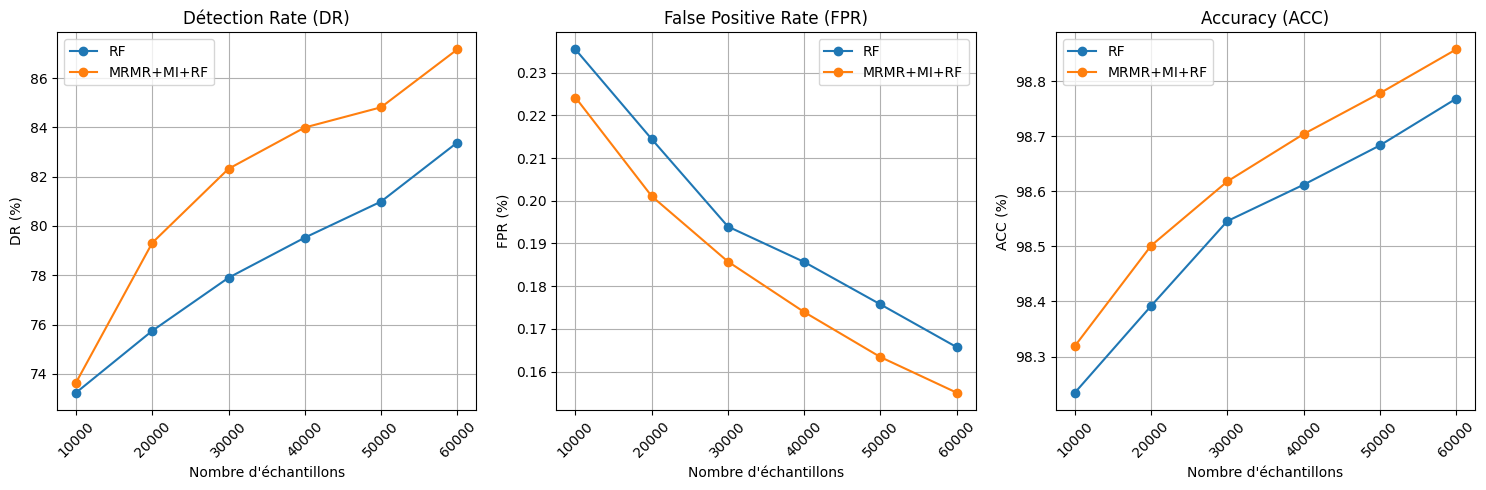

In [2]:
import pandas as pd 
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import gmean  # Import for geometric mean

def load_random_samples(filename, n_samples):
    df = pd.read_csv(filename)
    if len(df) < n_samples:
        raise ValueError(f"Not enough data in '{filename}': {len(df)} rows available, but {n_samples} required.")
    if len(df) > n_samples:
        return df.sample(n=n_samples, random_state=42)
    else:
        return df

# Chemins des dossiers
train_path = '/kaggle/input/ciciot2023/data/train'
test_path = '/kaggle/input/ciciot2023/data/test'

def mrmr_feature_selection(X, y, k=20):
   
    n_features = X.shape[1]
    
    # Normaliser les données pour de meilleures estimations d'information mutuelle
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Précalculer la matrice de redondance (MI entre toutes les paires de features)
    redundancy_matrix = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(i+1, n_features):
            mi_red = mutual_info_regression(X_normalized[:, i].reshape(-1, 1), 
                                           X_normalized[:, j])[0]
            redundancy_matrix[i, j] = mi_red
            redundancy_matrix[j, i] = mi_red
    
    # Relevance: MI entre chaque feature et la cible
    relevance = mutual_info_classif(X_normalized, y, random_state=42)
    
    selected_features = []
    remaining_features = list(range(n_features))
    
    for _ in range(k):
        candidate_scores = np.zeros(len(remaining_features))
        for idx, feat in enumerate(remaining_features):
            rel = relevance[feat]
            if selected_features:
                # Calculer la redondance avec moyenne géométrique (ajouter epsilon pour éviter zéro)
                redundancies = [redundancy_matrix[feat, sel_feat] + 1e-10 
                               for sel_feat in selected_features]
                redundancy = gmean(redundancies)
            else:
                redundancy = 0
            candidate_scores[idx] = rel - redundancy
        
        best_idx = np.argmax(candidate_scores)
        best_feat = remaining_features[best_idx]
        selected_features.append(best_feat)
        remaining_features.pop(best_idx)
    
    return selected_features

# Initialisation des listes pour stocker les métriques
DR_list_RF = []
FPR_list_RF = []
ACC_list_RF = []
DR_list_MRMR_MI_RF = []
FPR_list_MRMR_MI_RF = []
ACC_list_MRMR_MI_RF = []
sample_count_list = []


# Chargement des données de test 
benign_test = pd.read_csv(os.path.join(test_path, 'Benign_test.csv')).drop(columns=['Label'], errors='ignore')
ddos_test = pd.read_csv(os.path.join(test_path, 'DDoS_test.csv')).drop(columns=['Label'], errors='ignore')
dos_test = pd.read_csv(os.path.join(test_path, 'DoS_test.csv')).drop(columns=['Label'], errors='ignore')
mirai_test = pd.read_csv(os.path.join(test_path, 'Mirai_test.csv')).drop(columns=['Label'], errors='ignore')
recon_test = pd.read_csv(os.path.join(test_path, 'Recon_test.csv')).drop(columns=['Label'], errors='ignore')
spoofing_test = pd.read_csv(os.path.join(test_path, 'Spoofing_test.csv')).drop(columns=['Label'], errors='ignore')
webbased_test = pd.read_csv(os.path.join(test_path, 'Web-based_test.csv')).drop(columns=['Label'], errors='ignore')
bruteforce_test = pd.read_csv(os.path.join(test_path, 'Brute_Force_test.csv')).drop(columns=['Label'], errors='ignore')

# Création des labels de test
benign_test_labels = np.zeros(len(benign_test), dtype=int)
ddos_test_labels = np.ones(len(ddos_test), dtype=int)
dos_test_labels = np.full(len(dos_test), 2, dtype=int)
mirai_test_labels = np.full(len(mirai_test), 3, dtype=int)
recon_test_labels = np.full(len(recon_test), 4, dtype=int)
spoofing_test_labels = np.full(len(spoofing_test), 5, dtype=int)
webbased_test_labels = np.full(len(webbased_test), 6, dtype=int)
bruteforce_test_labels = np.full(len(bruteforce_test), 7, dtype=int)

# Fusion des données de test
TestMatrix = pd.concat([
    benign_test, ddos_test, dos_test, mirai_test,
    recon_test, spoofing_test, webbased_test, bruteforce_test
], ignore_index=True)
TestLabels = np.concatenate([
    benign_test_labels, ddos_test_labels, dos_test_labels, mirai_test_labels,
    recon_test_labels, spoofing_test_labels, webbased_test_labels, bruteforce_test_labels
])

# Gestion des valeurs infinies et manquantes pour le test
TestMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
TestMatrix.fillna(TestMatrix.mean(), inplace=True)


# Boucle sur P de 1 à 6
for P in range(1, 7):
    benign_train    = load_random_samples(os.path.join(train_path, 'Benign_train.csv'), 2229 * P).drop(columns=['Label'], errors='ignore')
    ddos_train      = load_random_samples(os.path.join(train_path, 'DDoS_train.csv'), 2704 * P).drop(columns=['Label'], errors='ignore')
    dos_train       = load_random_samples(os.path.join(train_path, 'DoS_train.csv'), 1307 * P).drop(columns=['Label'], errors='ignore')
    mirai_train     = load_random_samples(os.path.join(train_path, 'Mirai_train.csv'), 627 * P).drop(columns=['Label'], errors='ignore')
    recon_train     = load_random_samples(os.path.join(train_path, 'Recon_train.csv'), 940 * P).drop(columns=['Label'], errors='ignore')
    spoofing_train  = load_random_samples(os.path.join(train_path, 'Spoofing_train.csv'), 2066 * P).drop(columns=['Label'], errors='ignore')
    webbased_train  = load_random_samples(os.path.join(train_path, 'Web-based_train.csv'), 59 * P).drop(columns=['Label'], errors='ignore')
    bruteforce_train= load_random_samples(os.path.join(train_path, 'Brute_Force_train.csv'), 68 * P).drop(columns=['Label'], errors='ignore')

    # Création des labels d'entraînement
    benign_labels = np.zeros(len(benign_train), dtype=int)
    ddos_labels = np.ones(len(ddos_train), dtype=int)
    dos_labels = np.full(len(dos_train), 2, dtype=int)
    mirai_labels = np.full(len(mirai_train), 3, dtype=int)
    recon_labels = np.full(len(recon_train), 4, dtype=int)
    spoofing_labels = np.full(len(spoofing_train), 5, dtype=int)
    webbased_labels = np.full(len(webbased_train), 6, dtype=int)
    bruteforce_labels = np.full(len(bruteforce_train), 7, dtype=int)

    # Fusion des données d'entraînement
    TrainMatrix = pd.concat([
        benign_train, ddos_train, dos_train, mirai_train,
        recon_train, spoofing_train, webbased_train, bruteforce_train
    ], ignore_index=True)
    TrainLabels = np.concatenate([
        benign_labels, ddos_labels, dos_labels, mirai_labels,
        recon_labels, spoofing_labels, webbased_labels, bruteforce_labels
    ])

    # Gestion des valeurs infinies et manquantes pour l'entraînement
    TrainMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
    TrainMatrix.fillna(TrainMatrix.mean(), inplace=True)

    # --- Méthode Random Forest standard ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(TrainMatrix, TrainLabels)
    pred_labels = rf.predict(TestMatrix)

    # Calcul métriques pour RF standard
    conf_mat = confusion_matrix(TestLabels, pred_labels, labels=np.unique(TestLabels))
    TP = np.diag(conf_mat)
    FN = np.sum(conf_mat, axis=1) - TP
    FP = np.sum(conf_mat, axis=0) - TP
    TN = np.sum(conf_mat) - (TP + FP + FN)

    DR_RF = np.mean(TP / (TP + FN)) * 100
    FPR_RF = np.mean(FP / (FP + TN)) * 100
    ACC_RF = np.sum(TP) / np.sum(conf_mat) * 100

    # --- Méthode MRMR + MI + RF ---
    k = 20  # Nombre de caractéristiques à sélectionner
    # Use MRMR to select k=20 features (MRMR uses MI internally)
    selected_mrmr = mrmr_feature_selection(TrainMatrix.values, TrainLabels, k=k)
    TrainMatrix_mrmr = TrainMatrix.iloc[:, selected_mrmr].values
    TestMatrix_mrmr = TestMatrix.iloc[:, selected_mrmr].values

    # Entraînement RF sur caractéristiques sélectionnées par MRMR
    rf_mrmr = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_mrmr.fit(TrainMatrix_mrmr, TrainLabels)
    pred_labels_mrmr = rf_mrmr.predict(TestMatrix_mrmr)
    
    # Calcul métriques pour MRMR+MI+RF
    conf_mat_mrmr = confusion_matrix(TestLabels, pred_labels_mrmr, labels=np.unique(TestLabels))
    TP_mrmr = np.diag(conf_mat_mrmr)
    FN_mrmr = np.sum(conf_mat_mrmr, axis=1) - TP_mrmr
    FP_mrmr = np.sum(conf_mat_mrmr, axis=0) - TP_mrmr
    TN_mrmr = np.sum(conf_mat_mrmr) - (TP_mrmr + FP_mrmr + FN_mrmr)

    DR_MRMR_MI_RF = np.mean(TP_mrmr / (TP_mrmr + FN_mrmr)) * 100
    FPR_MRMR_MI_RF = np.mean(FP_mrmr / (FP_mrmr + TN_mrmr)) * 100
    ACC_MRMR_MI_RF = np.sum(TP_mrmr) / np.sum(conf_mat_mrmr) * 100

    print(f"P={P}:")
    print(f"  RF - DR={DR_RF:.2f}%, FPR={FPR_RF:.2f}%, ACC={ACC_RF:.2f}%")
    print(f"  MRMR+MI+RF - DR={DR_MRMR_MI_RF:.2f}%, FPR={FPR_MRMR_MI_RF:.2f}%, ACC={ACC_MRMR_MI_RF:.2f}%")

    # Sauvegarde des métriques
    DR_list_RF.append(DR_RF)
    FPR_list_RF.append(FPR_RF)
    ACC_list_RF.append(ACC_RF)
    DR_list_MRMR_MI_RF.append(DR_MRMR_MI_RF)
    FPR_list_MRMR_MI_RF.append(FPR_MRMR_MI_RF)
    ACC_list_MRMR_MI_RF.append(ACC_MRMR_MI_RF)
    sample_count_list.append(len(TrainMatrix))


plt.figure(figsize=(15, 5))

# DR comparison
plt.subplot(1, 3, 1)
plt.plot(sample_count_list, DR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, DR_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("DR (%)")
plt.title("Détection Rate (DR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# FPR comparison
plt.subplot(1, 3, 2)
plt.plot(sample_count_list, FPR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, FPR_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("FPR (%)")
plt.title("False Positive Rate (FPR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# ACC comparison
plt.subplot(1, 3, 3)
plt.plot(sample_count_list, ACC_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, ACC_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("ACC (%)")
plt.title("Accuracy (ACC)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

plt.tight_layout()
plt.show()

# Harmonic mean

P=1:
  RF - DR=73.23%, FPR=0.24%, ACC=98.23%
  MRMR+MI+RF - DR=74.56%, FPR=0.24%, ACC=98.24%
P=2:
  RF - DR=75.75%, FPR=0.21%, ACC=98.39%
  MRMR+MI+RF - DR=79.42%, FPR=0.21%, ACC=98.44%
P=3:
  RF - DR=77.90%, FPR=0.19%, ACC=98.55%
  MRMR+MI+RF - DR=82.81%, FPR=0.19%, ACC=98.59%
P=4:
  RF - DR=79.52%, FPR=0.19%, ACC=98.61%
  MRMR+MI+RF - DR=83.28%, FPR=0.18%, ACC=98.64%
P=5:
  RF - DR=80.99%, FPR=0.18%, ACC=98.68%
  MRMR+MI+RF - DR=85.03%, FPR=0.17%, ACC=98.74%
P=6:
  RF - DR=83.38%, FPR=0.17%, ACC=98.77%
  MRMR+MI+RF - DR=86.52%, FPR=0.16%, ACC=98.81%


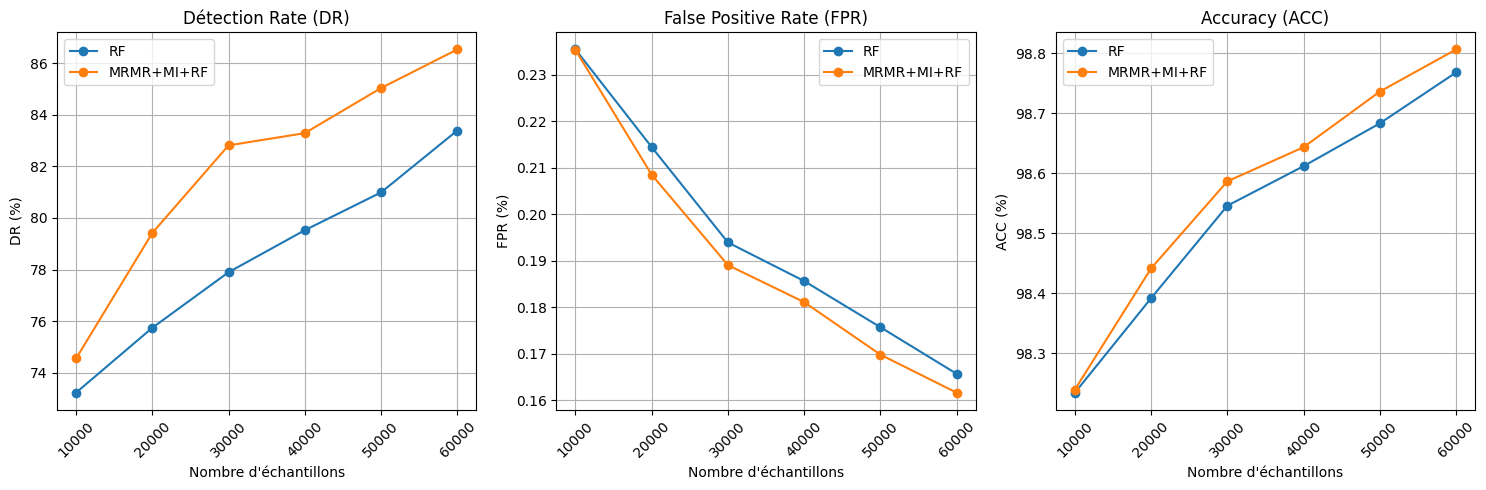

In [3]:
import pandas as pd 
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import hmean  # Import for harmonic mean

def load_random_samples(filename, n_samples):
    df = pd.read_csv(filename)
    if len(df) < n_samples:
        raise ValueError(f"Not enough data in '{filename}': {len(df)} rows available, but {n_samples} required.")
    if len(df) > n_samples:
        return df.sample(n=n_samples, random_state=42)
    else:
        return df

# Chemins des dossiers
train_path = '/kaggle/input/ciciot2023/data/train'
test_path = '/kaggle/input/ciciot2023/data/test'

def mrmr_feature_selection(X, y, k=20):
   
    n_features = X.shape[1]
    
    # Normaliser les données pour de meilleures estimations d'information mutuelle
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Précalculer la matrice de redondance (MI entre toutes les paires de features)
    redundancy_matrix = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(i+1, n_features):
            mi_red = mutual_info_regression(X_normalized[:, i].reshape(-1, 1), 
                                           X_normalized[:, j])[0]
            redundancy_matrix[i, j] = mi_red
            redundancy_matrix[j, i] = mi_red
    
    # Relevance: MI entre chaque feature et la cible
    relevance = mutual_info_classif(X_normalized, y, random_state=42)
    
    selected_features = []
    remaining_features = list(range(n_features))
    
    epsilon = 1e-10  # Small value to handle zero MI and avoid division by zero in hmean
    
    for _ in range(k):
        candidate_scores = np.zeros(len(remaining_features))
        for idx, feat in enumerate(remaining_features):
            rel = relevance[feat]
            if selected_features:
                # Calculer la redondance avec moyenne harmonique
                red_values = np.array([redundancy_matrix[feat, sel_feat] 
                                      for sel_feat in selected_features])
                redundancy = hmean(red_values + epsilon)
            else:
                redundancy = 0
            candidate_scores[idx] = rel - redundancy
        
        best_idx = np.argmax(candidate_scores)
        best_feat = remaining_features[best_idx]
        selected_features.append(best_feat)
        remaining_features.pop(best_idx)
    
    return selected_features

# Initialisation des listes pour stocker les métriques
DR_list_RF = []
FPR_list_RF = []
ACC_list_RF = []
DR_list_MRMR_MI_RF = []
FPR_list_MRMR_MI_RF = []
ACC_list_MRMR_MI_RF = []
sample_count_list = []


# Chargement des données de test 
benign_test = pd.read_csv(os.path.join(test_path, 'Benign_test.csv')).drop(columns=['Label'], errors='ignore')
ddos_test = pd.read_csv(os.path.join(test_path, 'DDoS_test.csv')).drop(columns=['Label'], errors='ignore')
dos_test = pd.read_csv(os.path.join(test_path, 'DoS_test.csv')).drop(columns=['Label'], errors='ignore')
mirai_test = pd.read_csv(os.path.join(test_path, 'Mirai_test.csv')).drop(columns=['Label'], errors='ignore')
recon_test = pd.read_csv(os.path.join(test_path, 'Recon_test.csv')).drop(columns=['Label'], errors='ignore')
spoofing_test = pd.read_csv(os.path.join(test_path, 'Spoofing_test.csv')).drop(columns=['Label'], errors='ignore')
webbased_test = pd.read_csv(os.path.join(test_path, 'Web-based_test.csv')).drop(columns=['Label'], errors='ignore')
bruteforce_test = pd.read_csv(os.path.join(test_path, 'Brute_Force_test.csv')).drop(columns=['Label'], errors='ignore')

# Création des labels de test
benign_test_labels = np.zeros(len(benign_test), dtype=int)
ddos_test_labels = np.ones(len(ddos_test), dtype=int)
dos_test_labels = np.full(len(dos_test), 2, dtype=int)
mirai_test_labels = np.full(len(mirai_test), 3, dtype=int)
recon_test_labels = np.full(len(recon_test), 4, dtype=int)
spoofing_test_labels = np.full(len(spoofing_test), 5, dtype=int)
webbased_test_labels = np.full(len(webbased_test), 6, dtype=int)
bruteforce_test_labels = np.full(len(bruteforce_test), 7, dtype=int)

# Fusion des données de test
TestMatrix = pd.concat([
    benign_test, ddos_test, dos_test, mirai_test,
    recon_test, spoofing_test, webbased_test, bruteforce_test
], ignore_index=True)
TestLabels = np.concatenate([
    benign_test_labels, ddos_test_labels, dos_test_labels, mirai_test_labels,
    recon_test_labels, spoofing_test_labels, webbased_test_labels, bruteforce_test_labels
])

# Gestion des valeurs infinies et manquantes pour le test
TestMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
TestMatrix.fillna(TestMatrix.mean(), inplace=True)


# Boucle sur P de 1 à 6
for P in range(1, 7):
    # Chargement des données d'entraînement avec P actuel
  
    benign_train    = load_random_samples(os.path.join(train_path, 'Benign_train.csv'), 2229 * P).drop(columns=['Label'], errors='ignore')
    ddos_train      = load_random_samples(os.path.join(train_path, 'DDoS_train.csv'), 2704 * P).drop(columns=['Label'], errors='ignore')
    dos_train       = load_random_samples(os.path.join(train_path, 'DoS_train.csv'), 1307 * P).drop(columns=['Label'], errors='ignore')
    mirai_train     = load_random_samples(os.path.join(train_path, 'Mirai_train.csv'), 627 * P).drop(columns=['Label'], errors='ignore')
    recon_train     = load_random_samples(os.path.join(train_path, 'Recon_train.csv'), 940 * P).drop(columns=['Label'], errors='ignore')
    spoofing_train  = load_random_samples(os.path.join(train_path, 'Spoofing_train.csv'), 2066 * P).drop(columns=['Label'], errors='ignore')
    webbased_train  = load_random_samples(os.path.join(train_path, 'Web-based_train.csv'), 59 * P).drop(columns=['Label'], errors='ignore')
    bruteforce_train= load_random_samples(os.path.join(train_path, 'Brute_Force_train.csv'), 68 * P).drop(columns=['Label'], errors='ignore')

    # Création des labels d'entraînement
    benign_labels = np.zeros(len(benign_train), dtype=int)
    ddos_labels = np.ones(len(ddos_train), dtype=int)
    dos_labels = np.full(len(dos_train), 2, dtype=int)
    mirai_labels = np.full(len(mirai_train), 3, dtype=int)
    recon_labels = np.full(len(recon_train), 4, dtype=int)
    spoofing_labels = np.full(len(spoofing_train), 5, dtype=int)
    webbased_labels = np.full(len(webbased_train), 6, dtype=int)
    bruteforce_labels = np.full(len(bruteforce_train), 7, dtype=int)

    # Fusion des données d'entraînement
    TrainMatrix = pd.concat([
        benign_train, ddos_train, dos_train, mirai_train,
        recon_train, spoofing_train, webbased_train, bruteforce_train
    ], ignore_index=True)
    TrainLabels = np.concatenate([
        benign_labels, ddos_labels, dos_labels, mirai_labels,
        recon_labels, spoofing_labels, webbased_labels, bruteforce_labels
    ])

    # Gestion des valeurs infinies et manquantes pour l'entraînement
    TrainMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
    TrainMatrix.fillna(TrainMatrix.mean(), inplace=True)

    # --- Méthode Random Forest standard ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(TrainMatrix, TrainLabels)
    pred_labels = rf.predict(TestMatrix)

    # Calcul métriques pour RF standard
    conf_mat = confusion_matrix(TestLabels, pred_labels, labels=np.unique(TestLabels))
    TP = np.diag(conf_mat)
    FN = np.sum(conf_mat, axis=1) - TP
    FP = np.sum(conf_mat, axis=0) - TP
    TN = np.sum(conf_mat) - (TP + FP + FN)

    DR_RF = np.mean(TP / (TP + FN)) * 100
    FPR_RF = np.mean(FP / (FP + TN)) * 100
    ACC_RF = np.sum(TP) / np.sum(conf_mat) * 100

    # --- Méthode MRMR + MI + RF ---
    k = 20  # Nombre de caractéristiques à sélectionner
    # Use MRMR to select k=20 features (MRMR uses MI internally)
    selected_mrmr = mrmr_feature_selection(TrainMatrix.values, TrainLabels, k=k)
    TrainMatrix_mrmr = TrainMatrix.iloc[:, selected_mrmr].values
    TestMatrix_mrmr = TestMatrix.iloc[:, selected_mrmr].values

    # Entraînement RF sur caractéristiques sélectionnées par MRMR
    rf_mrmr = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_mrmr.fit(TrainMatrix_mrmr, TrainLabels)
    pred_labels_mrmr = rf_mrmr.predict(TestMatrix_mrmr)
    
    # Calcul métriques pour MRMR+MI+RF
    conf_mat_mrmr = confusion_matrix(TestLabels, pred_labels_mrmr, labels=np.unique(TestLabels))
    TP_mrmr = np.diag(conf_mat_mrmr)
    FN_mrmr = np.sum(conf_mat_mrmr, axis=1) - TP_mrmr
    FP_mrmr = np.sum(conf_mat_mrmr, axis=0) - TP_mrmr
    TN_mrmr = np.sum(conf_mat_mrmr) - (TP_mrmr + FP_mrmr + FN_mrmr)

    DR_MRMR_MI_RF = np.mean(TP_mrmr / (TP_mrmr + FN_mrmr)) * 100
    FPR_MRMR_MI_RF = np.mean(FP_mrmr / (FP_mrmr + TN_mrmr)) * 100
    ACC_MRMR_MI_RF = np.sum(TP_mrmr) / np.sum(conf_mat_mrmr) * 100

    print(f"P={P}:")
    print(f"  RF - DR={DR_RF:.2f}%, FPR={FPR_RF:.2f}%, ACC={ACC_RF:.2f}%")
    print(f"  MRMR+MI+RF - DR={DR_MRMR_MI_RF:.2f}%, FPR={FPR_MRMR_MI_RF:.2f}%, ACC={ACC_MRMR_MI_RF:.2f}%")

    # Sauvegarde des métriques
    DR_list_RF.append(DR_RF)
    FPR_list_RF.append(FPR_RF)
    ACC_list_RF.append(ACC_RF)
    DR_list_MRMR_MI_RF.append(DR_MRMR_MI_RF)
    FPR_list_MRMR_MI_RF.append(FPR_MRMR_MI_RF)
    ACC_list_MRMR_MI_RF.append(ACC_MRMR_MI_RF)
    sample_count_list.append(len(TrainMatrix))


plt.figure(figsize=(15, 5))

# DR comparison
plt.subplot(1, 3, 1)
plt.plot(sample_count_list, DR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, DR_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("DR (%)")
plt.title("Détection Rate (DR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# FPR comparison
plt.subplot(1, 3, 2)
plt.plot(sample_count_list, FPR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, FPR_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("FPR (%)")
plt.title("False Positive Rate (FPR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# ACC comparison
plt.subplot(1, 3, 3)
plt.plot(sample_count_list, ACC_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, ACC_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("ACC (%)")
plt.title("Accuracy (ACC)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

plt.tight_layout()
plt.show()

# quadratic mean

P=1:
  RF - DR=73.23%, FPR=0.24%, ACC=98.23%
  MRMR+MI+RF - DR=74.29%, FPR=0.22%, ACC=98.37%
P=2:
  RF - DR=75.75%, FPR=0.21%, ACC=98.39%
  MRMR+MI+RF - DR=80.32%, FPR=0.20%, ACC=98.53%
P=3:
  RF - DR=77.90%, FPR=0.19%, ACC=98.55%
  MRMR+MI+RF - DR=83.18%, FPR=0.18%, ACC=98.68%
P=4:
  RF - DR=79.52%, FPR=0.19%, ACC=98.61%
  MRMR+MI+RF - DR=84.09%, FPR=0.17%, ACC=98.76%
P=5:
  RF - DR=80.99%, FPR=0.18%, ACC=98.68%
  MRMR+MI+RF - DR=85.81%, FPR=0.16%, ACC=98.85%
P=6:
  RF - DR=83.38%, FPR=0.17%, ACC=98.77%
  MRMR+MI+RF - DR=86.75%, FPR=0.15%, ACC=98.91%


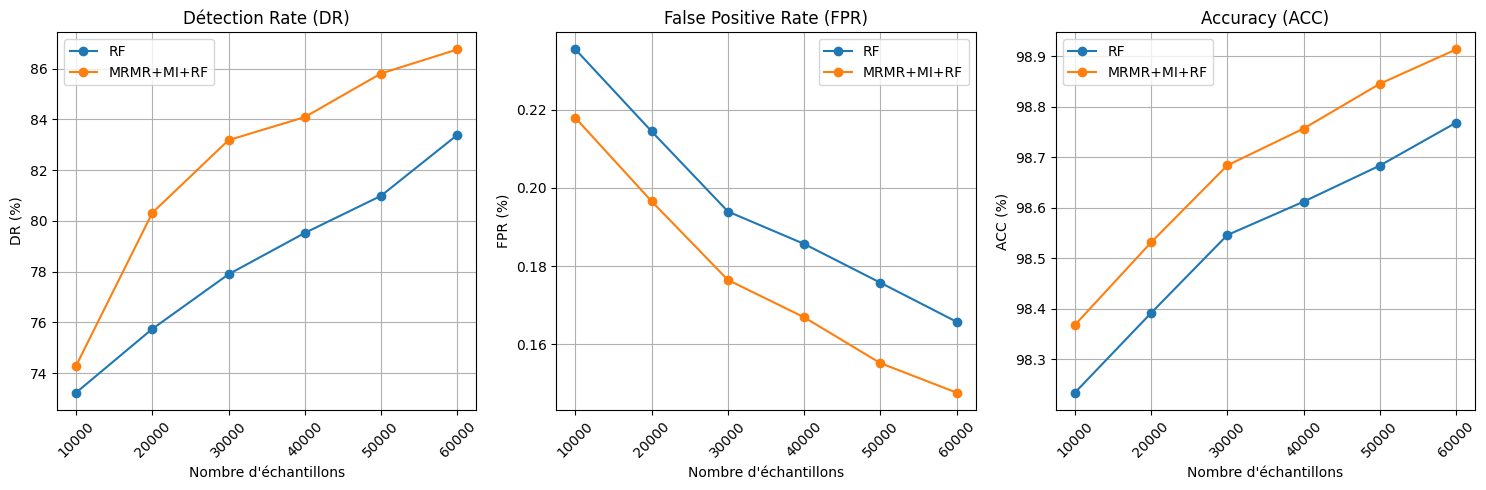

In [4]:
import pandas as pd 
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_random_samples(filename, n_samples):
    df = pd.read_csv(filename)
    if len(df) < n_samples:
        raise ValueError(f"Not enough data in '{filename}': {len(df)} rows available, but {n_samples} required.")
    if len(df) > n_samples:
        return df.sample(n=n_samples, random_state=42)
    else:
        return df

# Chemins des dossiers
train_path = '/kaggle/input/ciciot2023/data/train'
test_path = '/kaggle/input/ciciot2023/data/test'

def mrmr_feature_selection(X, y, k=20):
   
    n_features = X.shape[1]
    
    # Normaliser les données pour de meilleures estimations d'information mutuelle
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Précalculer la matrice de redondance (MI entre toutes les paires de features)
    redundancy_matrix = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(i+1, n_features):
            mi_red = mutual_info_regression(X_normalized[:, i].reshape(-1, 1), 
                                           X_normalized[:, j])[0]
            redundancy_matrix[i, j] = mi_red
            redundancy_matrix[j, i] = mi_red
    
    # Relevance: MI entre chaque feature et la cible
    relevance = mutual_info_classif(X_normalized, y, random_state=42)
    
    selected_features = []
    remaining_features = list(range(n_features))
    
    for _ in range(k):
        candidate_scores = np.zeros(len(remaining_features))
        for idx, feat in enumerate(remaining_features):
            rel = relevance[feat]
            if selected_features:
                # Calculer la redondance avec la moyenne quadratique (RMS)
                redundancies = [redundancy_matrix[feat, sel_feat] for sel_feat in selected_features]
                redundancy = np.sqrt(np.mean(np.square(redundancies)))
            else:
                redundancy = 0
            candidate_scores[idx] = rel - redundancy
        
        best_idx = np.argmax(candidate_scores)
        best_feat = remaining_features[best_idx]
        selected_features.append(best_feat)
        remaining_features.pop(best_idx)
    
    return selected_features

# Initialisation des listes pour stocker les métriques
DR_list_RF = []
FPR_list_RF = []
ACC_list_RF = []
DR_list_MRMR_MI_RF = []
FPR_list_MRMR_MI_RF = []
ACC_list_MRMR_MI_RF = []
sample_count_list = []


# Chargement des données de test 
benign_test = pd.read_csv(os.path.join(test_path, 'Benign_test.csv')).drop(columns=['Label'], errors='ignore')
ddos_test = pd.read_csv(os.path.join(test_path, 'DDoS_test.csv')).drop(columns=['Label'], errors='ignore')
dos_test = pd.read_csv(os.path.join(test_path, 'DoS_test.csv')).drop(columns=['Label'], errors='ignore')
mirai_test = pd.read_csv(os.path.join(test_path, 'Mirai_test.csv')).drop(columns=['Label'], errors='ignore')
recon_test = pd.read_csv(os.path.join(test_path, 'Recon_test.csv')).drop(columns=['Label'], errors='ignore')
spoofing_test = pd.read_csv(os.path.join(test_path, 'Spoofing_test.csv')).drop(columns=['Label'], errors='ignore')
webbased_test = pd.read_csv(os.path.join(test_path, 'Web-based_test.csv')).drop(columns=['Label'], errors='ignore')
bruteforce_test = pd.read_csv(os.path.join(test_path, 'Brute_Force_test.csv')).drop(columns=['Label'], errors='ignore')

# Création des labels de test
benign_test_labels = np.zeros(len(benign_test), dtype=int)
ddos_test_labels = np.ones(len(ddos_test), dtype=int)
dos_test_labels = np.full(len(dos_test), 2, dtype=int)
mirai_test_labels = np.full(len(mirai_test), 3, dtype=int)
recon_test_labels = np.full(len(recon_test), 4, dtype=int)
spoofing_test_labels = np.full(len(spoofing_test), 5, dtype=int)
webbased_test_labels = np.full(len(webbased_test), 6, dtype=int)
bruteforce_test_labels = np.full(len(bruteforce_test), 7, dtype=int)

# Fusion des données de test
TestMatrix = pd.concat([
    benign_test, ddos_test, dos_test, mirai_test,
    recon_test, spoofing_test, webbased_test, bruteforce_test
], ignore_index=True)
TestLabels = np.concatenate([
    benign_test_labels, ddos_test_labels, dos_test_labels, mirai_test_labels,
    recon_test_labels, spoofing_test_labels, webbased_test_labels, bruteforce_test_labels
])

# Gestion des valeurs infinies et manquantes pour le test
TestMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
TestMatrix.fillna(TestMatrix.mean(), inplace=True)


# Boucle sur P de 1 à 6
for P in range(1, 7):
    benign_train    = load_random_samples(os.path.join(train_path, 'Benign_train.csv'), 2229 * P).drop(columns=['Label'], errors='ignore')
    ddos_train      = load_random_samples(os.path.join(train_path, 'DDoS_train.csv'), 2704 * P).drop(columns=['Label'], errors='ignore')
    dos_train       = load_random_samples(os.path.join(train_path, 'DoS_train.csv'), 1307 * P).drop(columns=['Label'], errors='ignore')
    mirai_train     = load_random_samples(os.path.join(train_path, 'Mirai_train.csv'), 627 * P).drop(columns=['Label'], errors='ignore')
    recon_train     = load_random_samples(os.path.join(train_path, 'Recon_train.csv'), 940 * P).drop(columns=['Label'], errors='ignore')
    spoofing_train  = load_random_samples(os.path.join(train_path, 'Spoofing_train.csv'), 2066 * P).drop(columns=['Label'], errors='ignore')
    webbased_train  = load_random_samples(os.path.join(train_path, 'Web-based_train.csv'), 59 * P).drop(columns=['Label'], errors='ignore')
    bruteforce_train= load_random_samples(os.path.join(train_path, 'Brute_Force_train.csv'), 68 * P).drop(columns=['Label'], errors='ignore')
    # Création des labels d'entraînement
    benign_labels = np.zeros(len(benign_train), dtype=int)
    ddos_labels = np.ones(len(ddos_train), dtype=int)
    dos_labels = np.full(len(dos_train), 2, dtype=int)
    mirai_labels = np.full(len(mirai_train), 3, dtype=int)
    recon_labels = np.full(len(recon_train), 4, dtype=int)
    spoofing_labels = np.full(len(spoofing_train), 5, dtype=int)
    webbased_labels = np.full(len(webbased_train), 6, dtype=int)
    bruteforce_labels = np.full(len(bruteforce_train), 7, dtype=int)

    # Fusion des données d'entraînement
    TrainMatrix = pd.concat([
        benign_train, ddos_train, dos_train, mirai_train,
        recon_train, spoofing_train, webbased_train, bruteforce_train
    ], ignore_index=True)
    TrainLabels = np.concatenate([
        benign_labels, ddos_labels, dos_labels, mirai_labels,
        recon_labels, spoofing_labels, webbased_labels, bruteforce_labels
    ])

    # Gestion des valeurs infinies et manquantes pour l'entraînement
    TrainMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
    TrainMatrix.fillna(TrainMatrix.mean(), inplace=True)

    # --- Méthode Random Forest standard ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(TrainMatrix, TrainLabels)
    pred_labels = rf.predict(TestMatrix)

    # Calcul métriques pour RF standard
    conf_mat = confusion_matrix(TestLabels, pred_labels, labels=np.unique(TestLabels))
    TP = np.diag(conf_mat)
    FN = np.sum(conf_mat, axis=1) - TP
    FP = np.sum(conf_mat, axis=0) - TP
    TN = np.sum(conf_mat) - (TP + FP + FN)

    DR_RF = np.mean(TP / (TP + FN)) * 100
    FPR_RF = np.mean(FP / (FP + TN)) * 100
    ACC_RF = np.sum(TP) / np.sum(conf_mat) * 100

    # --- Méthode MRMR + MI + RF ---
    k = 20  # Nombre de caractéristiques à sélectionner
    # Use MRMR to select k=20 features (MRMR uses MI internally)
    selected_mrmr = mrmr_feature_selection(TrainMatrix.values, TrainLabels, k=k)
    TrainMatrix_mrmr = TrainMatrix.iloc[:, selected_mrmr].values
    TestMatrix_mrmr = TestMatrix.iloc[:, selected_mrmr].values

    # Entraînement RF sur caractéristiques sélectionnées par MRMR
    rf_mrmr = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_mrmr.fit(TrainMatrix_mrmr, TrainLabels)
    pred_labels_mrmr = rf_mrmr.predict(TestMatrix_mrmr)
    
    # Calcul métriques pour MRMR+MI+RF
    conf_mat_mrmr = confusion_matrix(TestLabels, pred_labels_mrmr, labels=np.unique(TestLabels))
    TP_mrmr = np.diag(conf_mat_mrmr)
    FN_mrmr = np.sum(conf_mat_mrmr, axis=1) - TP_mrmr
    FP_mrmr = np.sum(conf_mat_mrmr, axis=0) - TP_mrmr
    TN_mrmr = np.sum(conf_mat_mrmr) - (TP_mrmr + FP_mrmr + FN_mrmr)

    DR_MRMR_MI_RF = np.mean(TP_mrmr / (TP_mrmr + FN_mrmr)) * 100
    FPR_MRMR_MI_RF = np.mean(FP_mrmr / (FP_mrmr + TN_mrmr)) * 100
    ACC_MRMR_MI_RF = np.sum(TP_mrmr) / np.sum(conf_mat_mrmr) * 100

    print(f"P={P}:")
    print(f"  RF - DR={DR_RF:.2f}%, FPR={FPR_RF:.2f}%, ACC={ACC_RF:.2f}%")
    print(f"  MRMR+MI+RF - DR={DR_MRMR_MI_RF:.2f}%, FPR={FPR_MRMR_MI_RF:.2f}%, ACC={ACC_MRMR_MI_RF:.2f}%")

    # Sauvegarde des métriques
    DR_list_RF.append(DR_RF)
    FPR_list_RF.append(FPR_RF)
    ACC_list_RF.append(ACC_RF)
    DR_list_MRMR_MI_RF.append(DR_MRMR_MI_RF)
    FPR_list_MRMR_MI_RF.append(FPR_MRMR_MI_RF)
    ACC_list_MRMR_MI_RF.append(ACC_MRMR_MI_RF)
    sample_count_list.append(len(TrainMatrix))


plt.figure(figsize=(15, 5))

# DR comparison
plt.subplot(1, 3, 1)
plt.plot(sample_count_list, DR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, DR_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("DR (%)")
plt.title("Détection Rate (DR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# FPR comparison
plt.subplot(1, 3, 2)
plt.plot(sample_count_list, FPR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, FPR_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("FPR (%)")
plt.title("False Positive Rate (FPR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# ACC comparison
plt.subplot(1, 3, 3)
plt.plot(sample_count_list, ACC_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, ACC_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("ACC (%)")
plt.title("Accuracy (ACC)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

plt.tight_layout()
plt.show()

# exponential 

P=1:
  RF - DR=73.23%, FPR=0.24%, ACC=98.23%
  MRMR+EMA+MI+RF - DR=74.32%, FPR=0.22%, ACC=98.33%
P=2:
  RF - DR=75.75%, FPR=0.21%, ACC=98.39%
  MRMR+EMA+MI+RF - DR=80.39%, FPR=0.20%, ACC=98.49%
P=3:
  RF - DR=77.90%, FPR=0.19%, ACC=98.55%
  MRMR+EMA+MI+RF - DR=83.87%, FPR=0.19%, ACC=98.59%
P=4:
  RF - DR=79.52%, FPR=0.19%, ACC=98.61%
  MRMR+EMA+MI+RF - DR=84.00%, FPR=0.18%, ACC=98.66%
P=5:
  RF - DR=80.99%, FPR=0.18%, ACC=98.68%
  MRMR+EMA+MI+RF - DR=85.71%, FPR=0.17%, ACC=98.75%
P=6:
  RF - DR=83.38%, FPR=0.17%, ACC=98.77%
  MRMR+EMA+MI+RF - DR=86.54%, FPR=0.16%, ACC=98.84%


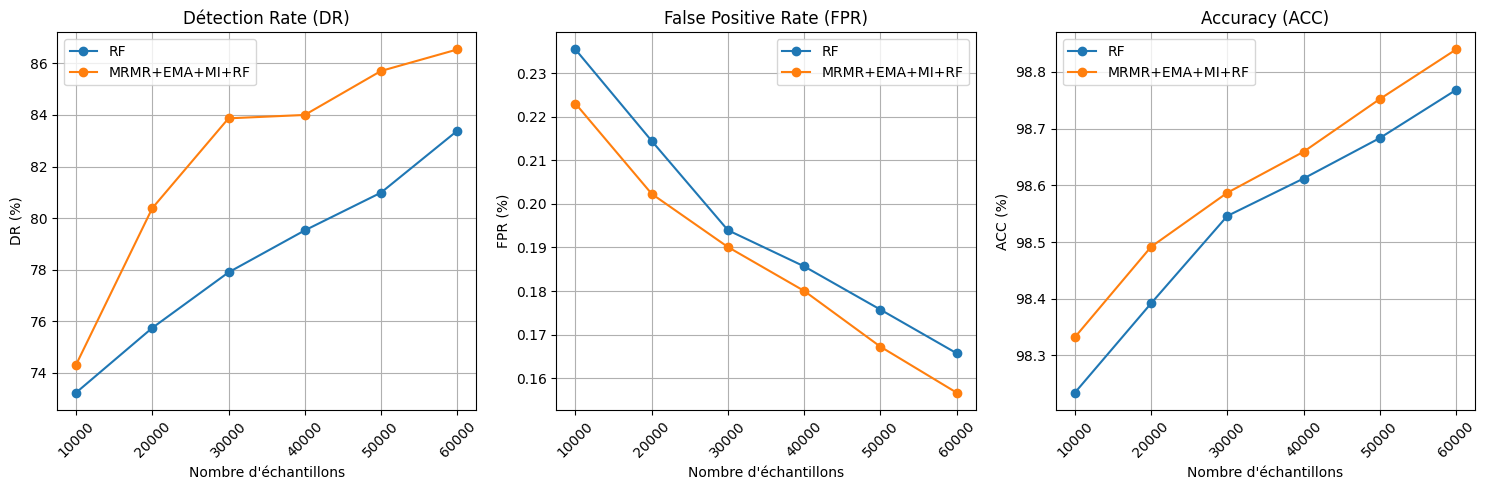

In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_random_samples(filename, n_samples):
    df = pd.read_csv(filename)
    if len(df) < n_samples:
        raise ValueError(f"Not enough data in '{filename}': {len(df)} rows available, but {n_samples} required.")
    if len(df) > n_samples:
        return df.sample(n=n_samples, random_state=42)
    else:
        return df

# Chemins des dossiers
train_path = '/kaggle/input/ciciot2023/data/train'
test_path = '/kaggle/input/ciciot2023/data/test'

def mrmr_feature_selection(X, y, k=20, alpha=0.9):
    n_features = X.shape[1]
    
    # Normaliser les données pour de meilleures estimations d'information mutuelle
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Précalculer la matrice de redondance (MI entre toutes les paires de features)
    redundancy_matrix = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(i+1, n_features):
            mi_red = mutual_info_regression(X_normalized[:, i].reshape(-1, 1), 
                                           X_normalized[:, j])[0]
            redundancy_matrix[i, j] = mi_red
            redundancy_matrix[j, i] = mi_red
    
    # Relevance: MI entre chaque feature et la cible
    relevance = mutual_info_classif(X_normalized, y, random_state=42)
    
    selected_features = []
    remaining_features = list(range(n_features))
    
    for _ in range(k):
        candidate_scores = np.zeros(len(remaining_features))
        for idx, feat in enumerate(remaining_features):
            rel = relevance[feat]
            if selected_features:
                # Calculer la redondance avec EMA au lieu de la moyenne simple
                red_list = np.array([redundancy_matrix[feat, sel_feat] for sel_feat in selected_features])
                m = len(red_list)
                if m > 0:
                    exp_arr = np.arange(m-1, -1, -1)  # m-1 down to 0 for exponential decay from oldest to newest
                    weights = alpha * (1 - alpha) ** exp_arr
                    sum_weights = 1 - (1 - alpha) ** m
                    redundancy = np.sum(weights * red_list) / sum_weights
                else:
                    redundancy = 0
            else:
                redundancy = 0
            candidate_scores[idx] = rel - redundancy
        
        best_idx = np.argmax(candidate_scores)
        best_feat = remaining_features[best_idx]
        selected_features.append(best_feat)
        remaining_features.pop(best_idx)
    
    return selected_features

# Initialisation des listes pour stocker les métriques
DR_list_RF = []
FPR_list_RF = []
ACC_list_RF = []
DR_list_MRMR_MI_RF = []
FPR_list_MRMR_MI_RF = []
ACC_list_MRMR_MI_RF = []
sample_count_list = []

# Chargement des données de test 
benign_test = pd.read_csv(os.path.join(test_path, 'Benign_test.csv')).drop(columns=['Label'], errors='ignore')
ddos_test = pd.read_csv(os.path.join(test_path, 'DDoS_test.csv')).drop(columns=['Label'], errors='ignore')
dos_test = pd.read_csv(os.path.join(test_path, 'DoS_test.csv')).drop(columns=['Label'], errors='ignore')
mirai_test = pd.read_csv(os.path.join(test_path, 'Mirai_test.csv')).drop(columns=['Label'], errors='ignore')
recon_test = pd.read_csv(os.path.join(test_path, 'Recon_test.csv')).drop(columns=['Label'], errors='ignore')
spoofing_test = pd.read_csv(os.path.join(test_path, 'Spoofing_test.csv')).drop(columns=['Label'], errors='ignore')
webbased_test = pd.read_csv(os.path.join(test_path, 'Web-based_test.csv')).drop(columns=['Label'], errors='ignore')
bruteforce_test = pd.read_csv(os.path.join(test_path, 'Brute_Force_test.csv')).drop(columns=['Label'], errors='ignore')

# Création des labels de test
benign_test_labels = np.zeros(len(benign_test), dtype=int)
ddos_test_labels = np.ones(len(ddos_test), dtype=int)
dos_test_labels = np.full(len(dos_test), 2, dtype=int)
mirai_test_labels = np.full(len(mirai_test), 3, dtype=int)
recon_test_labels = np.full(len(recon_test), 4, dtype=int)
spoofing_test_labels = np.full(len(spoofing_test), 5, dtype=int)
webbased_test_labels = np.full(len(webbased_test), 6, dtype=int)
bruteforce_test_labels = np.full(len(bruteforce_test), 7, dtype=int)

# Fusion des données de test
TestMatrix = pd.concat([
    benign_test, ddos_test, dos_test, mirai_test,
    recon_test, spoofing_test, webbased_test, bruteforce_test
], ignore_index=True)
TestLabels = np.concatenate([
    benign_test_labels, ddos_test_labels, dos_test_labels, mirai_test_labels,
    recon_test_labels, spoofing_test_labels, webbased_test_labels, bruteforce_test_labels
])

# Gestion des valeurs infinies et manquantes pour le test
TestMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
TestMatrix.fillna(TestMatrix.mean(), inplace=True)

# Boucle sur P de 1 à 6
for P in range(1, 7):
    benign_train    = load_random_samples(os.path.join(train_path, 'Benign_train.csv'), 2229 * P).drop(columns=['Label'], errors='ignore')
    ddos_train      = load_random_samples(os.path.join(train_path, 'DDoS_train.csv'), 2704 * P).drop(columns=['Label'], errors='ignore')
    dos_train       = load_random_samples(os.path.join(train_path, 'DoS_train.csv'), 1307 * P).drop(columns=['Label'], errors='ignore')
    mirai_train     = load_random_samples(os.path.join(train_path, 'Mirai_train.csv'), 627 * P).drop(columns=['Label'], errors='ignore')
    recon_train     = load_random_samples(os.path.join(train_path, 'Recon_train.csv'), 940 * P).drop(columns=['Label'], errors='ignore')
    spoofing_train  = load_random_samples(os.path.join(train_path, 'Spoofing_train.csv'), 2066 * P).drop(columns=['Label'], errors='ignore')
    webbased_train  = load_random_samples(os.path.join(train_path, 'Web-based_train.csv'), 59 * P).drop(columns=['Label'], errors='ignore')
    bruteforce_train= load_random_samples(os.path.join(train_path, 'Brute_Force_train.csv'), 68 * P).drop(columns=['Label'], errors='ignore')
    # Création des labels d'entraînement
    benign_labels = np.zeros(len(benign_train), dtype=int)
    ddos_labels = np.ones(len(ddos_train), dtype=int)
    dos_labels = np.full(len(dos_train), 2, dtype=int)
    mirai_labels = np.full(len(mirai_train), 3, dtype=int)
    recon_labels = np.full(len(recon_train), 4, dtype=int)
    spoofing_labels = np.full(len(spoofing_train), 5, dtype=int)
    webbased_labels = np.full(len(webbased_train), 6, dtype=int)
    bruteforce_labels = np.full(len(bruteforce_train), 7, dtype=int)

    # Fusion des données d'entraînement
    TrainMatrix = pd.concat([
        benign_train, ddos_train, dos_train, mirai_train,
        recon_train, spoofing_train, webbased_train, bruteforce_train
    ], ignore_index=True)
    TrainLabels = np.concatenate([
        benign_labels, ddos_labels, dos_labels, mirai_labels,
        recon_labels, spoofing_labels, webbased_labels, bruteforce_labels
    ])

    # Gestion des valeurs infinies et manquantes pour l'entraînement
    TrainMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
    TrainMatrix.fillna(TrainMatrix.mean(), inplace=True)

    # --- Méthode Random Forest standard ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(TrainMatrix, TrainLabels)
    pred_labels = rf.predict(TestMatrix)

    # Calcul métriques pour RF standard
    conf_mat = confusion_matrix(TestLabels, pred_labels, labels=np.unique(TestLabels))
    TP = np.diag(conf_mat)
    FN = np.sum(conf_mat, axis=1) - TP
    FP = np.sum(conf_mat, axis=0) - TP
    TN = np.sum(conf_mat) - (TP + FP + FN)

    DR_RF = np.mean(TP / (TP + FN)) * 100
    FPR_RF = np.mean(FP / (FP + TN)) * 100
    ACC_RF = np.sum(TP) / np.sum(conf_mat) * 100

    # --- Méthode MRMR + MI + RF avec EMA pour redondance ---
    k = 20  # Nombre de caractéristiques à sélectionner
    # Use MRMR with EMA to select k=20 features
    selected_mrmr = mrmr_feature_selection(TrainMatrix.values, TrainLabels, k=k, alpha=0.9)
    TrainMatrix_mrmr = TrainMatrix.iloc[:, selected_mrmr].values
    TestMatrix_mrmr = TestMatrix.iloc[:, selected_mrmr].values

    # Entraînement RF sur caractéristiques sélectionnées par MRMR avec EMA
    rf_mrmr = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_mrmr.fit(TrainMatrix_mrmr, TrainLabels)
    pred_labels_mrmr = rf_mrmr.predict(TestMatrix_mrmr)
    
    # Calcul métriques pour MRMR+MI+RF avec EMA
    conf_mat_mrmr = confusion_matrix(TestLabels, pred_labels_mrmr, labels=np.unique(TestLabels))
    TP_mrmr = np.diag(conf_mat_mrmr)
    FN_mrmr = np.sum(conf_mat_mrmr, axis=1) - TP_mrmr
    FP_mrmr = np.sum(conf_mat_mrmr, axis=0) - TP_mrmr
    TN_mrmr = np.sum(conf_mat_mrmr) - (TP_mrmr + FP_mrmr + FN_mrmr)

    DR_MRMR_MI_RF = np.mean(TP_mrmr / (TP_mrmr + FN_mrmr)) * 100
    FPR_MRMR_MI_RF = np.mean(FP_mrmr / (FP_mrmr + TN_mrmr)) * 100
    ACC_MRMR_MI_RF = np.sum(TP_mrmr) / np.sum(conf_mat_mrmr) * 100

    print(f"P={P}:")
    print(f"  RF - DR={DR_RF:.2f}%, FPR={FPR_RF:.2f}%, ACC={ACC_RF:.2f}%")
    print(f"  MRMR+EMA+MI+RF - DR={DR_MRMR_MI_RF:.2f}%, FPR={FPR_MRMR_MI_RF:.2f}%, ACC={ACC_MRMR_MI_RF:.2f}%")

    # Sauvegarde des métriques
    DR_list_RF.append(DR_RF)
    FPR_list_RF.append(FPR_RF)
    ACC_list_RF.append(ACC_RF)
    DR_list_MRMR_MI_RF.append(DR_MRMR_MI_RF)
    FPR_list_MRMR_MI_RF.append(FPR_MRMR_MI_RF)
    ACC_list_MRMR_MI_RF.append(ACC_MRMR_MI_RF)
    sample_count_list.append(len(TrainMatrix))

plt.figure(figsize=(15, 5))

# DR comparison
plt.subplot(1, 3, 1)
plt.plot(sample_count_list, DR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, DR_list_MRMR_MI_RF, marker='o', label="MRMR+EMA+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("DR (%)")
plt.title("Détection Rate (DR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# FPR comparison
plt.subplot(1, 3, 2)
plt.plot(sample_count_list, FPR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, FPR_list_MRMR_MI_RF, marker='o', label="MRMR+EMA+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("FPR (%)")
plt.title("False Positive Rate (FPR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# ACC comparison
plt.subplot(1, 3, 3)
plt.plot(sample_count_list, ACC_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, ACC_list_MRMR_MI_RF, marker='o', label="MRMR+EMA+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("ACC (%)")
plt.title("Accuracy (ACC)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

plt.tight_layout()
plt.show()

# Median

P=1:
  RF - DR=73.23%, FPR=0.24%, ACC=98.23%
  MRMR+MI+RF - DR=74.91%, FPR=0.23%, ACC=98.29%
P=2:
  RF - DR=75.75%, FPR=0.21%, ACC=98.39%
  MRMR+MI+RF - DR=78.92%, FPR=0.21%, ACC=98.44%
P=3:
  RF - DR=77.90%, FPR=0.19%, ACC=98.55%
  MRMR+MI+RF - DR=82.41%, FPR=0.19%, ACC=98.56%
P=4:
  RF - DR=79.52%, FPR=0.19%, ACC=98.61%
  MRMR+MI+RF - DR=83.40%, FPR=0.18%, ACC=98.64%
P=5:
  RF - DR=80.99%, FPR=0.18%, ACC=98.68%
  MRMR+MI+RF - DR=85.16%, FPR=0.17%, ACC=98.73%
P=6:
  RF - DR=83.38%, FPR=0.17%, ACC=98.77%
  MRMR+MI+RF - DR=86.27%, FPR=0.16%, ACC=98.82%


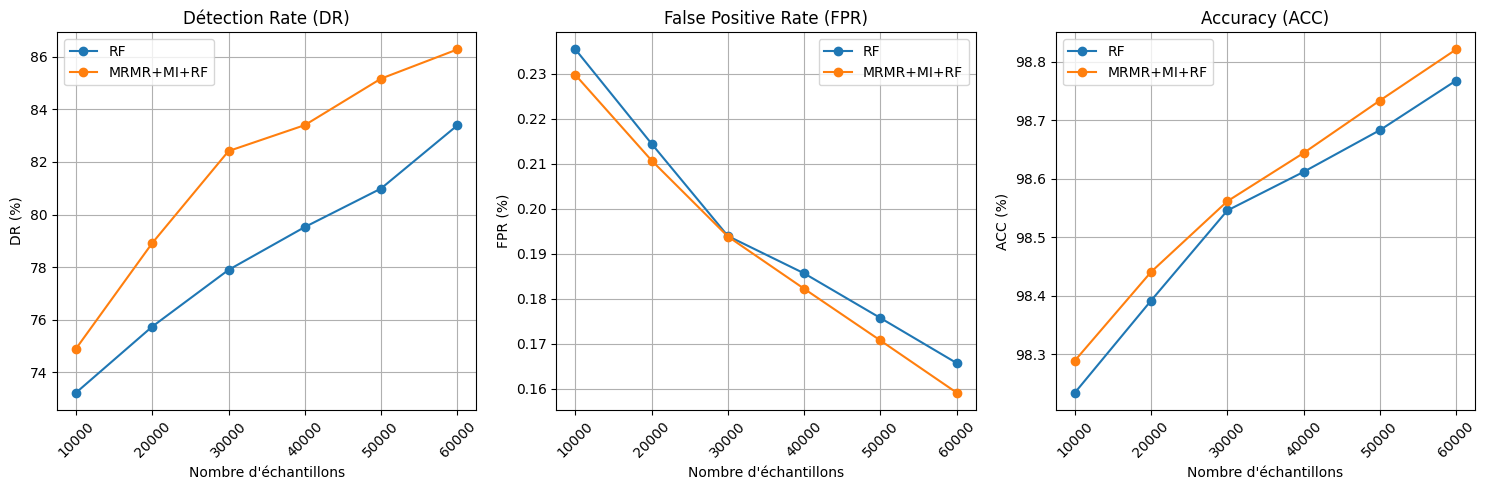

In [6]:
import pandas as pd 
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_random_samples(filename, n_samples):
    df = pd.read_csv(filename)
    if len(df) < n_samples:
        raise ValueError(f"Not enough data in '{filename}': {len(df)} rows available, but {n_samples} required.")
    if len(df) > n_samples:
        return df.sample(n=n_samples, random_state=42)
    else:
        return df

# Chemins des dossiers
train_path = '/kaggle/input/ciciot2023/data/train'
test_path = '/kaggle/input/ciciot2023/data/test'

def mrmr_feature_selection(X, y, k=20):
   
    n_features = X.shape[1]
    
    # Normaliser les données pour de meilleures estimations d'information mutuelle
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Précalculer la matrice de redondance (MI entre toutes les paires de features)
    redundancy_matrix = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(i+1, n_features):
            mi_red = mutual_info_regression(X_normalized[:, i].reshape(-1, 1), 
                                           X_normalized[:, j])[0]
            redundancy_matrix[i, j] = mi_red
            redundancy_matrix[j, i] = mi_red
    
    # Relevance: MI entre chaque feature et la cible
    relevance = mutual_info_classif(X_normalized, y, random_state=42)
    
    selected_features = []
    remaining_features = list(range(n_features))
    
    for _ in range(k):
        candidate_scores = np.zeros(len(remaining_features))
        for idx, feat in enumerate(remaining_features):
            rel = relevance[feat]
            if selected_features:
                # Calculer la redondance médiane avec les features déjà sélectionnées
                redundancy = np.median([redundancy_matrix[feat, sel_feat] 
                                     for sel_feat in selected_features])
            else:
                redundancy = 0
            candidate_scores[idx] = rel - redundancy
        
        best_idx = np.argmax(candidate_scores)
        best_feat = remaining_features[best_idx]
        selected_features.append(best_feat)
        remaining_features.pop(best_idx)
    
    return selected_features

# Initialisation des listes pour stocker les métriques
DR_list_RF = []
FPR_list_RF = []
ACC_list_RF = []
DR_list_MRMR_MI_RF = []
FPR_list_MRMR_MI_RF = []
ACC_list_MRMR_MI_RF = []
sample_count_list = []


# Chargement des données de test 
benign_test = pd.read_csv(os.path.join(test_path, 'Benign_test.csv')).drop(columns=['Label'], errors='ignore')
ddos_test = pd.read_csv(os.path.join(test_path, 'DDoS_test.csv')).drop(columns=['Label'], errors='ignore')
dos_test = pd.read_csv(os.path.join(test_path, 'DoS_test.csv')).drop(columns=['Label'], errors='ignore')
mirai_test = pd.read_csv(os.path.join(test_path, 'Mirai_test.csv')).drop(columns=['Label'], errors='ignore')
recon_test = pd.read_csv(os.path.join(test_path, 'Recon_test.csv')).drop(columns=['Label'], errors='ignore')
spoofing_test = pd.read_csv(os.path.join(test_path, 'Spoofing_test.csv')).drop(columns=['Label'], errors='ignore')
webbased_test = pd.read_csv(os.path.join(test_path, 'Web-based_test.csv')).drop(columns=['Label'], errors='ignore')
bruteforce_test = pd.read_csv(os.path.join(test_path, 'Brute_Force_test.csv')).drop(columns=['Label'], errors='ignore')

# Création des labels de test
benign_test_labels = np.zeros(len(benign_test), dtype=int)
ddos_test_labels = np.ones(len(ddos_test), dtype=int)
dos_test_labels = np.full(len(dos_test), 2, dtype=int)
mirai_test_labels = np.full(len(mirai_test), 3, dtype=int)
recon_test_labels = np.full(len(recon_test), 4, dtype=int)
spoofing_test_labels = np.full(len(spoofing_test), 5, dtype=int)
webbased_test_labels = np.full(len(webbased_test), 6, dtype=int)
bruteforce_test_labels = np.full(len(bruteforce_test), 7, dtype=int)

# Fusion des données de test
TestMatrix = pd.concat([
    benign_test, ddos_test, dos_test, mirai_test,
    recon_test, spoofing_test, webbased_test, bruteforce_test
], ignore_index=True)
TestLabels = np.concatenate([
    benign_test_labels, ddos_test_labels, dos_test_labels, mirai_test_labels,
    recon_test_labels, spoofing_test_labels, webbased_test_labels, bruteforce_test_labels
])

# Gestion des valeurs infinies et manquantes pour le test
TestMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
TestMatrix.fillna(TestMatrix.mean(), inplace=True)


# Boucle sur P de 1 à 6
for P in range(1, 7):
    benign_train    = load_random_samples(os.path.join(train_path, 'Benign_train.csv'), 2229 * P).drop(columns=['Label'], errors='ignore')
    ddos_train      = load_random_samples(os.path.join(train_path, 'DDoS_train.csv'), 2704 * P).drop(columns=['Label'], errors='ignore')
    dos_train       = load_random_samples(os.path.join(train_path, 'DoS_train.csv'), 1307 * P).drop(columns=['Label'], errors='ignore')
    mirai_train     = load_random_samples(os.path.join(train_path, 'Mirai_train.csv'), 627 * P).drop(columns=['Label'], errors='ignore')
    recon_train     = load_random_samples(os.path.join(train_path, 'Recon_train.csv'), 940 * P).drop(columns=['Label'], errors='ignore')
    spoofing_train  = load_random_samples(os.path.join(train_path, 'Spoofing_train.csv'), 2066 * P).drop(columns=['Label'], errors='ignore')
    webbased_train  = load_random_samples(os.path.join(train_path, 'Web-based_train.csv'), 59 * P).drop(columns=['Label'], errors='ignore')
    bruteforce_train= load_random_samples(os.path.join(train_path, 'Brute_Force_train.csv'), 68 * P).drop(columns=['Label'], errors='ignore')

    # Création des labels d'entraînement
    benign_labels = np.zeros(len(benign_train), dtype=int)
    ddos_labels = np.ones(len(ddos_train), dtype=int)
    dos_labels = np.full(len(dos_train), 2, dtype=int)
    mirai_labels = np.full(len(mirai_train), 3, dtype=int)
    recon_labels = np.full(len(recon_train), 4, dtype=int)
    spoofing_labels = np.full(len(spoofing_train), 5, dtype=int)
    webbased_labels = np.full(len(webbased_train), 6, dtype=int)
    bruteforce_labels = np.full(len(bruteforce_train), 7, dtype=int)

    # Fusion des données d'entraînement
    TrainMatrix = pd.concat([
        benign_train, ddos_train, dos_train, mirai_train,
        recon_train, spoofing_train, webbased_train, bruteforce_train
    ], ignore_index=True)
    TrainLabels = np.concatenate([
        benign_labels, ddos_labels, dos_labels, mirai_labels,
        recon_labels, spoofing_labels, webbased_labels, bruteforce_labels
    ])

    # Gestion des valeurs infinies et manquantes pour l'entraînement
    TrainMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
    TrainMatrix.fillna(TrainMatrix.mean(), inplace=True)

    # --- Méthode Random Forest standard ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(TrainMatrix, TrainLabels)
    pred_labels = rf.predict(TestMatrix)

    # Calcul métriques pour RF standard
    conf_mat = confusion_matrix(TestLabels, pred_labels, labels=np.unique(TestLabels))
    TP = np.diag(conf_mat)
    FN = np.sum(conf_mat, axis=1) - TP
    FP = np.sum(conf_mat, axis=0) - TP
    TN = np.sum(conf_mat) - (TP + FP + FN)

    DR_RF = np.mean(TP / (TP + FN)) * 100
    FPR_RF = np.mean(FP / (FP + TN)) * 100
    ACC_RF = np.sum(TP) / np.sum(conf_mat) * 100

    # --- Méthode MRMR + MI + RF ---
    k = 20  # Nombre de caractéristiques à sélectionner
    # Use MRMR to select k=20 features (MRMR uses MI internally)
    selected_mrmr = mrmr_feature_selection(TrainMatrix.values, TrainLabels, k=k)
    TrainMatrix_mrmr = TrainMatrix.iloc[:, selected_mrmr].values
    TestMatrix_mrmr = TestMatrix.iloc[:, selected_mrmr].values

    # Entraînement RF sur caractéristiques sélectionnées par MRMR
    rf_mrmr = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_mrmr.fit(TrainMatrix_mrmr, TrainLabels)
    pred_labels_mrmr = rf_mrmr.predict(TestMatrix_mrmr)
    
    # Calcul métriques pour MRMR+MI+RF
    conf_mat_mrmr = confusion_matrix(TestLabels, pred_labels_mrmr, labels=np.unique(TestLabels))
    TP_mrmr = np.diag(conf_mat_mrmr)
    FN_mrmr = np.sum(conf_mat_mrmr, axis=1) - TP_mrmr
    FP_mrmr = np.sum(conf_mat_mrmr, axis=0) - TP_mrmr
    TN_mrmr = np.sum(conf_mat_mrmr) - (TP_mrmr + FP_mrmr + FN_mrmr)

    DR_MRMR_MI_RF = np.mean(TP_mrmr / (TP_mrmr + FN_mrmr)) * 100
    FPR_MRMR_MI_RF = np.mean(FP_mrmr / (FP_mrmr + TN_mrmr)) * 100
    ACC_MRMR_MI_RF = np.sum(TP_mrmr) / np.sum(conf_mat_mrmr) * 100

    print(f"P={P}:")
    print(f"  RF - DR={DR_RF:.2f}%, FPR={FPR_RF:.2f}%, ACC={ACC_RF:.2f}%")
    print(f"  MRMR+MI+RF - DR={DR_MRMR_MI_RF:.2f}%, FPR={FPR_MRMR_MI_RF:.2f}%, ACC={ACC_MRMR_MI_RF:.2f}%")

    # Sauvegarde des métriques
    DR_list_RF.append(DR_RF)
    FPR_list_RF.append(FPR_RF)
    ACC_list_RF.append(ACC_RF)
    DR_list_MRMR_MI_RF.append(DR_MRMR_MI_RF)
    FPR_list_MRMR_MI_RF.append(FPR_MRMR_MI_RF)
    ACC_list_MRMR_MI_RF.append(ACC_MRMR_MI_RF)
    sample_count_list.append(len(TrainMatrix))


plt.figure(figsize=(15, 5))

# DR comparison
plt.subplot(1, 3, 1)
plt.plot(sample_count_list, DR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, DR_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("DR (%)")
plt.title("Détection Rate (DR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# FPR comparison
plt.subplot(1, 3, 2)
plt.plot(sample_count_list, FPR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, FPR_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("FPR (%)")
plt.title("False Positive Rate (FPR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# ACC comparison
plt.subplot(1, 3, 3)
plt.plot(sample_count_list, ACC_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, ACC_list_MRMR_MI_RF, marker='o', label="MRMR+MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("ACC (%)")
plt.title("Accuracy (ACC)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

plt.tight_layout()
plt.show()